### author: zabiralnazi@yahoo.com
> 0.40 Dropout, Transfer Learning

In [0]:
## data_seg.zip URL: https://drive.google.com/open?id=15Bav4EU2fEKMB76zerubFNIUkJjqy7V2

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
% cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
# ! ls

In [0]:
import os
print(os.stat('/content/drive/My Drive/data_seg.zip').st_size/1000000000) # GigaBytes (approx)

0.019925205


In [0]:
% cd /content/

/content


In [0]:
! ls

drive  sample_data


In [0]:
# unzip to train_imgs folder
data_seg = '/content/drive/My Drive/data_seg.zip'
import zipfile
zip_ref = zipfile.ZipFile(data_seg, 'r')
zip_ref.extractall('img_seg')
zip_ref.close()

In [0]:
! ls

drive  img_seg	sample_data


In [0]:
% cd /content/img_seg/data_seg

/content/img_seg/data_seg


In [0]:
! ls

test  train


In [0]:
import glob
img_files_tv = [] # train, validation
for files in glob.glob('/content/img_seg/data_seg/train/image/*.png'):
    img_files_tv.append(files)

mask_files_tv = []
for files in glob.glob('/content/img_seg/data_seg/train/label/*.png'):
    mask_files_tv.append(files)

In [0]:
print(len(img_files_tv))
print(len(mask_files_tv))

170
170


In [0]:
img_files_tst = [] # train, validation
for files in glob.glob('/content/img_seg/data_seg/test/image/*.png'):
    img_files_tst.append(files)

mask_files_tst = []
for files in glob.glob('/content/img_seg/data_seg/test/label/*.png'):
    mask_files_tst.append(files)

In [0]:
print(len(img_files_tst))
print(len(mask_files_tst))

30
30


In [0]:
# To reproduce the results later
from numpy.random import seed
seed(1997)
from tensorflow import set_random_seed
set_random_seed(1997)

In [0]:
# reference: https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras import backend as K
from keras.layers.merge import concatenate
from keras.utils.data_utils import get_file

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights


def preprocess_input(x):
    x /= 255.
    # not sure about the mean of the image distribution
    return x


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # +1 added to avoid 0/0 division
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def double_conv_layer(x, size, dropout=0.5, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(dropout_val=0.5, weights=None): # No dropout by default
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    model = Model(inputs, conv_final, name="UNET_224")


    return model

Using TensorFlow backend.


In [0]:
import cv2
import random
import numpy as np
import pandas as pd
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import __version__

img_files_tv.sort()
mask_files_tv.sort()

img_files_tst.sort()
mask_files_tst.sort()

print('Updated States ...')
img_arr = []
mask_arr = []
num_train = len(img_files_tv)
global gen_batch 

Updated States ...


In [0]:
import random
random.seed(1997) # same seed again
for i in range(num_train):
    a = cv2.imread(img_files_tv[i])
    #a = cv2.resize(a, (224, 224)) 
    a = np.array(a,dtype=np.uint8)
    img_arr.append(a)

    b = cv2.imread(mask_files_tv[i],0)
    b = cv2.resize(b, (224, 224)) 
    b = np.array(b,dtype=np.uint8)
    mask_arr.append(b)
    
    
for i in range(len(img_files_tst)):
    a = cv2.imread(img_files_tst[i])
    #a = cv2.resize(a, (224, 224)) 
    a = np.array(a,dtype=np.uint8)
    img_arr.append(a)

    b = cv2.imread(mask_files_tst[i],0)
    b = cv2.resize(b, (224, 224)) 
    b = np.array(b,dtype=np.uint8)
    mask_arr.append(b)
    
print(len(img_arr))
print(len(mask_arr))
    
gen_batch = 0

fin_arr = list(zip(img_arr,mask_arr))
random.shuffle(fin_arr)
img_arr = [x[0] for x in fin_arr]
mask_arr = [x[1] for x in fin_arr]

200
200


In [0]:
tot_data = len(img_arr)
print(tot_data)
train_split = 0.5
validation_split = 0.5 + 0.2
test_split = 0.5 + 0.2 + 0.3

train_img = img_arr[:int(tot_data*train_split)]
validation_img = img_arr[int(tot_data*train_split):int(tot_data*validation_split)]
test_img = img_arr[int(tot_data*validation_split):]

train_mask = mask_arr[:int(tot_data*train_split)]
validation_mask = mask_arr[int(tot_data*train_split):int(tot_data*validation_split)]
test_mask = mask_arr[int(tot_data*validation_split):]

print(len(train_img))
print(len(train_mask))

print(len(validation_img))
print(len(validation_mask))

print(len(test_img))
print(len(test_mask))

200
100
100
40
40
60
60


In [0]:
train_img = np.array(train_img, dtype = 'float32')
train_img = preprocess_input(train_img)
validation_img = np.array(validation_img, dtype = 'float32')
validation_img = preprocess_input(validation_img)
test_img = np.array(test_img, dtype = 'float32')
test_img = preprocess_input(test_img)

In [0]:
print(np.max(train_img[0]))
print(np.max(validation_img[0]))
print(np.max(test_img[0]))

print(np.min(train_img[0]))
print(np.min(validation_img[0]))
print(np.min(test_img[0]))

1.0
1.0
1.0
0.003921569
0.0
0.019607844


In [0]:
train_mask = np.array(train_mask, dtype = 'float32')
train_mask = preprocess_input(train_mask)
validation_mask = np.array(validation_mask, dtype = 'float32')
validation_mask = preprocess_input(validation_mask)
test_mask = np.array(test_mask, dtype = 'float32')
test_mask = preprocess_input(test_mask)

In [0]:
print(np.max(train_mask[0]))
print(np.max(validation_mask[0]))
print(np.max(test_mask[0]))

print(np.min(train_mask[0]))
print(np.min(validation_mask[0]))
print(np.min(test_mask[0]))

1.0
1.0
1.0
0.0
0.0
0.0


In [0]:
print(train_img[0].shape)
print(train_mask[0].shape)

(224, 224, 3)
(224, 224)


In [0]:
print(train_mask.shape)
n_s, r, c = train_mask.shape
train_mask = train_mask.reshape(n_s, r, c, 1)
print(train_mask.shape)

(100, 224, 224)
(100, 224, 224, 1)


In [0]:
print(validation_mask.shape)
n_s, r, c = validation_mask.shape
validation_mask = validation_mask.reshape(n_s, r, c, 1)
print(validation_mask.shape)

(40, 224, 224)
(40, 224, 224, 1)


In [0]:
print(test_mask.shape)
n_s, r, c = test_mask.shape
test_mask = test_mask.reshape(n_s, r, c, 1)
print(test_mask.shape)

(60, 224, 224)
(60, 224, 224, 1)


In [0]:
print(os.stat('/content/drive/My Drive/unet_224_best_weight_drop_aug.h5').st_size/1000000000) # GigaBytes (approx)

0.377860192


In [0]:
from keras.models import load_model
import os

out_model_path = 'unet_224_final_model_tf_ph2.h5'

pretrained_weights = '/content/drive/My Drive/unet_224_best_weight_drop_aug.h5'
epochs = 20
patience = 20
batch_size = 32
optim_type = 'Adam'
learning_rate = 0.001
model = UNET_224()

#if os.path.isfile(out_model_path):

model.load_weights(pretrained_weights)

if optim_type == 'SGD':
    optim = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
else:
    optim = Adam(lr=learning_rate)
model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef, jacard_coef])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
    #EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
    ModelCheckpoint('unet_224_best_weight.h5', monitor='val_loss', save_best_only=True, verbose=1),
]

print('Training Init()')
history = model.fit(
    x = train_img,
    y = train_mask,
    batch_size = batch_size,
    epochs=epochs,
    #steps_per_epoch= 1815//batch_size,
    validation_data= (validation_img, validation_mask),
    #validation_steps= 389//16,
    verbose=1,
    callbacks=callbacks)

model.save(out_model_path)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


Training Init()
Train on 100 samples, validate on 40 samples
Epoch 1/20
100/100 [==============================] - 23s 234ms/step - loss: -0.9029 - dice_coef: 0.9029 - jacard_coef: 0.8234 - val_loss: -0.8242 - val_dice_coef: 0.8242 - val_jacard_coef: 0.7010

Epoch 00001: val_loss improved from inf to -0.82420, saving model to unet_224_best_weight.h5
Epoch 2/20
100/100 [==============================] - 6s 57ms/step - loss: -0.9156 - dice_coef: 0.9156 - jacard_coef: 0.8445 - val_loss: -0.8627 - val_dice_coef: 0.8627 - val_jacard_coef: 0.7586

Epoch 00002: val_loss improved from -0.82420 to -0.86267, saving model to unet_224_best_weight.h5
Epoch 3/20
100/100 [==============================] - 6s 55ms/step - loss: -0.9351 - dice_coef: 0.9351 - jacard_coef: 0.8781 - val_loss: -0.8454 - val_dice_coef: 0.8454 - val_jacard_coef: 0.7321

Epoch 00003: val_loss did not improve from -0.86267
Epoch 4/20
100/100 [==============================] - 6s 55ms/step - loss: -0.9331 - dice_coef: 0.9331 - j

In [0]:
predicted_mask = model.predict(test_img)

In [0]:
predicted_mask.shape

(60, 224, 224, 1)

In [0]:
def dice_coef_eval(y_true, y_pred):
    y_p = y_pred.flatten()
    #print(y_p.shape)
    y_b = y_true.flatten()
    #print(y_b.shape)
    cc = np.dot(y_p,y_b)
    #print(cc)
    ps = np.sum(y_p)
    pb = np.sum(y_b)
    ds = (2.0*cc + 1.0)/(ps+pb+1.0)
    #print(type(ds))
    return ds
  
def jacard_coef_eval(y_true, y_pred):
    y_p = y_pred.flatten()
    #print(y_p.shape)
    y_b = y_true.flatten()
    #print(y_b.shape)
    cc = np.dot(y_p,y_b)
    #print(cc)
    ps = np.sum(y_p)
    pb = np.sum(y_b)
    js = (cc + 1.0)/(ps+pb-cc+1.0)
    #print(type(ds))
    return js

In [0]:
# binary conversion
predicted_mask[predicted_mask<0.5] = 0.0
predicted_mask[predicted_mask>=0.5] = 1.0

In [0]:
dice_score_test = []
jacard_score_test = []

n_s, r, c, ch = predicted_mask.shape
for i in range(n_s):
    dice_score_test.append(dice_coef_eval(predicted_mask[i,:,:,:], test_mask[i,:,:,:]))
    jacard_score_test.append(jacard_coef_eval(predicted_mask[i,:,:,:], test_mask[i,:,:,:]))

In [0]:
print(np.mean(dice_score_test))
print(2.0*np.std(dice_score_test))

print(np.mean(jacard_score_test))
print(2.0*np.std(jacard_score_test))

0.9275341766948207
0.12618068346026734
0.8704893363514875
0.19190177857078056


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive

In [0]:
np.save('img_test.npy', test_img)
np.save('img_mask.npy', test_mask)
np.save('y_predicted_test.npy', predicted_mask)
np.save('model.hist.npy', history.history)

In [0]:
# saving to google drive for backup


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'img_mask_ph2_tl.npy'})
uploaded.SetContentFile('img_mask.npy')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 18ayvAUBCTmxnKuW4D06PB7ERN6MdC1dq


In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'img_test_ph2_tl.npy'})
uploaded.SetContentFile('img_test.npy')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1sdMO6dSdY33Fi36URsKctQviDHfFQxzb


In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'y_predicted_ph2_tl.npy'})
uploaded.SetContentFile('y_predicted_test.npy')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1aNSIYWoOAKDVc6x-am5zcHMrvSjGPf09


In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model.hist_ph2_tl.npy'})
uploaded.SetContentFile('model.hist.npy')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 11o3uiC9UA2UMqrqygJlxxECRMRQv7rep


In [0]:
a = history.history
np.save('a.npy', a)
# a = [()]
a = np.load('a.npy')
print(type(a))

<class 'numpy.ndarray'>


In [0]:
a = a[()]
print(type(a))

<class 'dict'>


In [0]:
# a['loss']

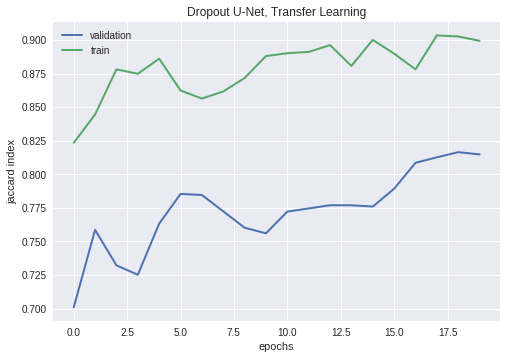

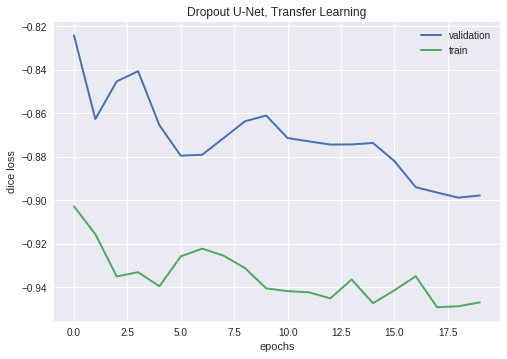

In [0]:
import matplotlib.pyplot as plt

# plot_init()
plt.title('Dropout U-Net, Transfer Learning')
plt.xlabel('epochs')
plt.ylabel('jaccard index')
plt.plot(range(len(a['val_jacard_coef'])), a['val_jacard_coef'], 
         label = 'validation', linewidth=2.0)
plt.plot(range(len(a['jacard_coef'])), a['jacard_coef'],
        label = 'train', linewidth=2.0)
plt.legend()
# save_plot('unet_jaccard')
plt.show()





# plot_init()
plt.title('Dropout U-Net, Transfer Learning')
plt.xlabel('epochs')
plt.ylabel('dice loss')
plt.plot(range(len(a['val_loss'])), a['val_loss'], 
         label = 'validation', linewidth=2.0)
plt.plot(range(len(a['loss'])), a['loss'],
        label = 'train', linewidth=2.0)
plt.legend()
# save_plot('unet_loss')
plt.show()
